In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from torch import optim
from dreamz.render import train_visualiser
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [3]:
device = 'cuda'

In [4]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [5]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

In [6]:
widths = [20] * 8
base = CPPNNet(widths, output_channels=widths[-1])
viz = UpsampleNet(base, reps=1).to(device)

In [14]:
def imgnet_objective(output, _):
    r = model((output - mean) / std)
#     return torch.mean((r - targ) ** 2)
    return -r[:, 30].mean()

size = [59, 105]
xy = get_xy_mesh(size).to(device)
def im_gen_fn(pct_done=0.0, num=16):
    xy_crop = []
    for i in range(num):
        x0 = np.random.randint(0, 105 - 59)
        xy_crop.append(xy[:, :, :, x0:x0 + 59])
    xy_crop = torch.cat(xy_crop, 0)
    return viz(xy_crop), None

In [15]:
opt = optim.Adam(viz.parameters(), lr=0.002)
div = 10

  0%|          | 0/150 [00:00<?, ?it/s]

cost -0.0396033450961113


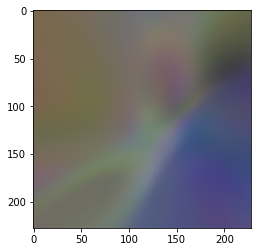

  3%|▎         | 5/150 [00:00<00:20,  7.18it/s]

cost -0.23211628198623657


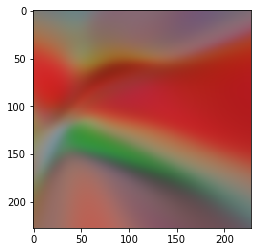

  5%|▍         | 7/150 [00:00<00:19,  7.24it/s]

cost -0.4129425287246704


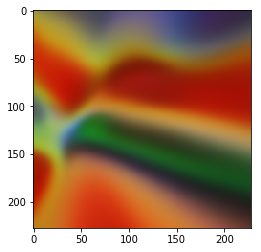

 10%|█         | 15/150 [00:01<00:12, 10.77it/s]

cost -0.5546218156814575


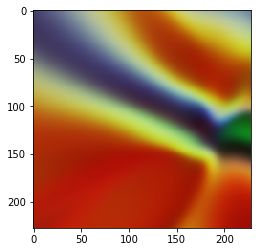

 11%|█▏        | 17/150 [00:01<00:13,  9.66it/s]

cost -0.720955491065979


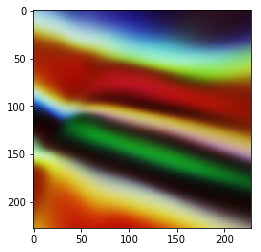

 17%|█▋        | 25/150 [00:01<00:09, 13.18it/s]

cost -0.7914276719093323


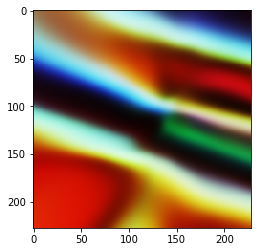

 19%|█▊        | 28/150 [00:01<00:09, 12.28it/s]

cost -0.8788758516311646


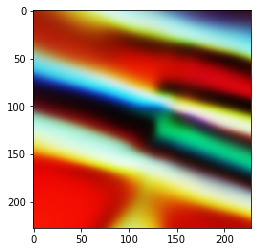

 23%|██▎       | 35/150 [00:02<00:08, 14.36it/s]

cost -0.8662227988243103


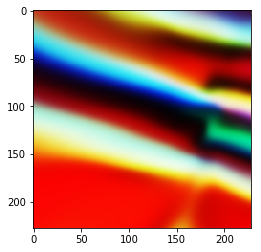

 25%|██▌       | 38/150 [00:02<00:08, 13.20it/s]

cost -0.9625458717346191


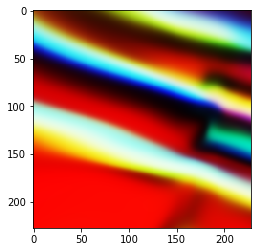

 30%|███       | 45/150 [00:03<00:07, 14.94it/s]

cost -1.0428625345230103


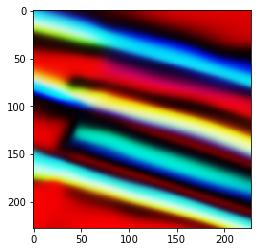

 32%|███▏      | 48/150 [00:03<00:07, 13.46it/s]

cost -1.130732774734497


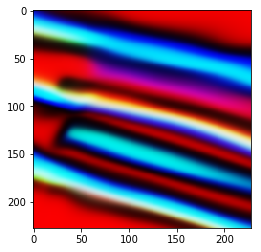

 37%|███▋      | 55/150 [00:03<00:06, 15.12it/s]

cost -1.200817346572876


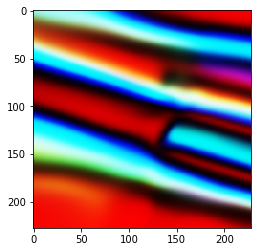

 39%|███▊      | 58/150 [00:04<00:06, 13.65it/s]

cost -1.2358133792877197


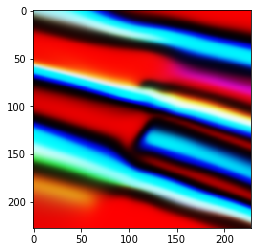

 43%|████▎     | 65/150 [00:04<00:05, 15.17it/s]

cost -1.271005392074585


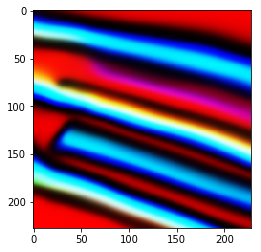

 45%|████▌     | 68/150 [00:04<00:06, 13.64it/s]

cost -1.306361198425293


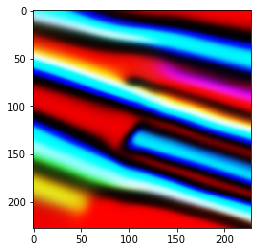

 50%|█████     | 75/150 [00:05<00:04, 15.16it/s]

cost -1.316366195678711


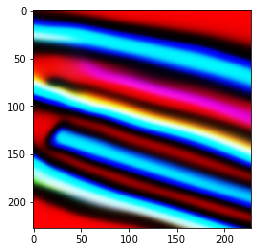

 52%|█████▏    | 78/150 [00:05<00:05, 13.66it/s]

cost -1.3406827449798584


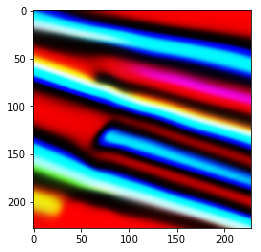

 57%|█████▋    | 85/150 [00:05<00:04, 15.16it/s]

cost -1.3332014083862305


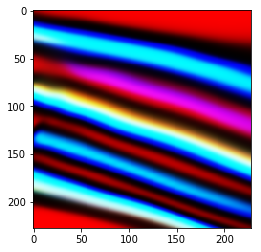

 59%|█████▊    | 88/150 [00:06<00:04, 13.82it/s]

cost -1.3553335666656494


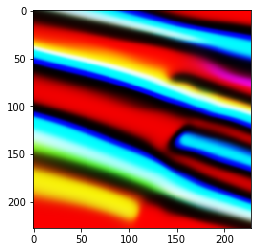

 63%|██████▎   | 95/150 [00:06<00:03, 14.35it/s]

cost -1.3668477535247803


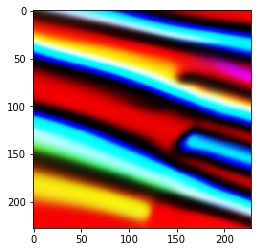

 65%|██████▌   | 98/150 [00:06<00:03, 13.30it/s]

cost -1.3902660608291626


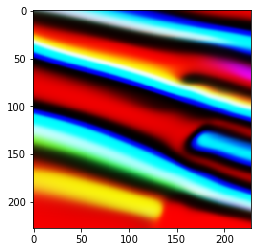

 70%|███████   | 105/150 [00:07<00:03, 14.96it/s]

cost -1.3904868364334106


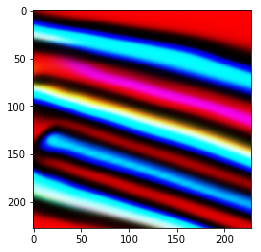

 72%|███████▏  | 108/150 [00:07<00:03, 13.65it/s]

cost -1.400034785270691


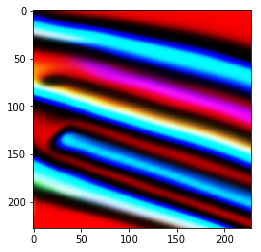

 77%|███████▋  | 115/150 [00:07<00:02, 15.20it/s]

cost -1.4160362482070923


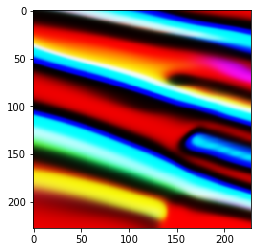

 79%|███████▊  | 118/150 [00:08<00:02, 13.76it/s]

cost -1.4146709442138672


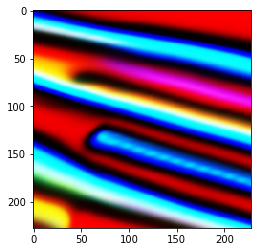

 83%|████████▎ | 125/150 [00:08<00:01, 15.29it/s]

cost -1.4459664821624756


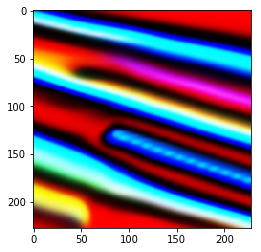

 85%|████████▌ | 128/150 [00:08<00:01, 13.76it/s]

cost -1.4551030397415161


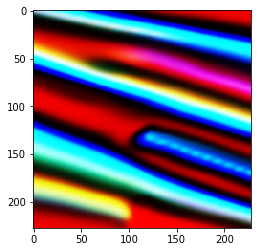

 90%|█████████ | 135/150 [00:09<00:00, 15.24it/s]

cost -1.4614018201828003


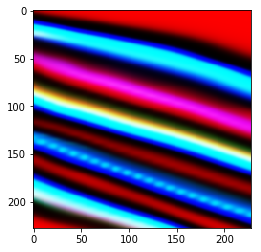

 92%|█████████▏| 138/150 [00:09<00:00, 13.75it/s]

cost -1.5125961303710938


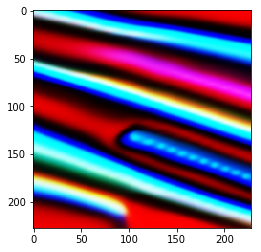

 97%|█████████▋| 145/150 [00:10<00:00, 15.17it/s]

cost -1.5398778915405273


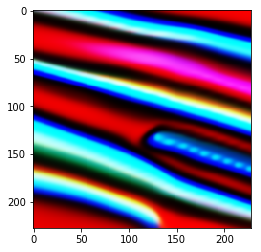

100%|██████████| 150/150 [00:10<00:00, 14.45it/s]


In [16]:
train_visualiser(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

In [17]:
xy_big = get_xy_mesh([277, 502]).to(device)

In [20]:
res = viz(xy_big)

In [21]:
%timeit viz(xy_big)

12.1 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


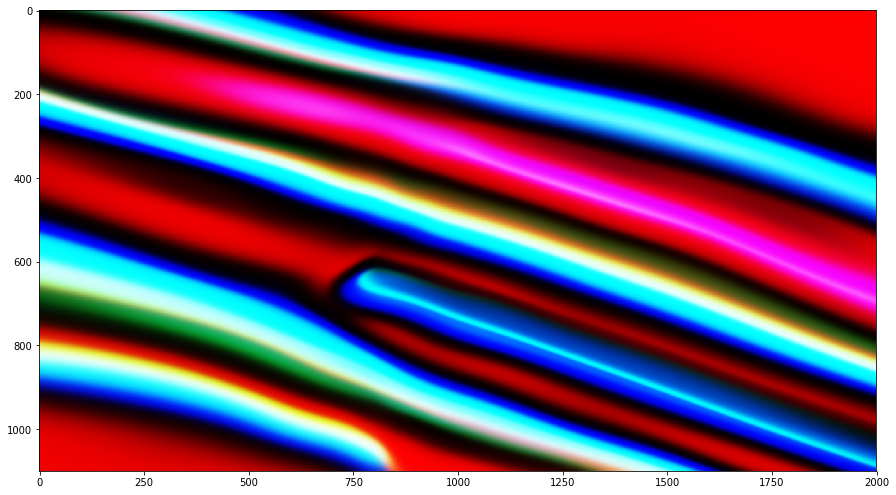

In [22]:
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)